Prepare fasttext file

In [1]:
import pandas as pd
data = pd.read_json("bcs_polsent.jsonl", orient="records", lines=True)

In [2]:
data = data.loc[ :, ["sentence", "label", "split"]]
data.head()

,sentence,label,split
0,Ja shvatam da međunarodna zajednica i oni koji...,Negative,test
1,"Npr. mene i moje braće, npr. mi tražimo našu i...",Negative,train
2,"Pa normalno da nije, ali vidite, pustite kad m...",Negative,test
3,"Pomoći ovim ljudima, da danas ti ljudi mogu i ...",Negative,test
4,"Dakle, uz puno uvažavanje, ovo što zna element...",Negative,train


In [3]:
train = data[data.split=="train"]
test = data[data.split=="test"]
dev = data[data.split=="dev"]

In [4]:
!mkdir fasttext_data

mkdir: cannot create directory ‘fasttext_data’: File exists


In [5]:
with open("fasttext_data/train.txt", "w") as f:
    for i, row in train.iterrows():
        f.write(f"__label__{row['label']} {row['sentence']}\n")
with open("fasttext_data/test.txt", "w") as f:
    for i, row in test.iterrows():
        f.write(f"__label__{row['label']} {row['sentence']}\n")
with open("fasttext_data/dev.txt", "w") as f:
    for i, row in dev.iterrows():
        f.write(f"__label__{row['label']} {row['sentence']}\n")

In [6]:
import fasttext

In [7]:
import numpy as np

epochs = [3, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 30, 50, 100]
f1s = []
f1s_emb = []
from tqdm.auto import tqdm
for epoch in tqdm(epochs):
    model = fasttext.train_supervised(input="fasttext_data/train.txt", epoch=epoch)
    y_pred = model.predict(dev.sentence.tolist())[0]
    y_pred = [i[0][9:] for i in y_pred]
    y_true = dev.label.tolist()

    from sklearn.metrics import f1_score

    f1 = f1_score(
        y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
    )
    f1s.append(f1)

    model = fasttext.train_supervised(
        input="fasttext_data/train.txt",
        epoch=epoch,
        pretrainedVectors="fasttext_embeddings/embed.hr-token.ft.sg.vec",
    )
    y_pred = model.predict(dev.sentence.tolist())[0]
    y_pred = [i[0][9:] for i in y_pred]
    y_true = dev.label.tolist()

    from sklearn.metrics import f1_score

    f1 = f1_score(
        y_true, y_pred, average="macro", labels=["Positive", "Neutral", "Negative"]
    )
    f1s_emb.append(f1)


  0%|          | 0/17 [00:00<?, ?it/s]

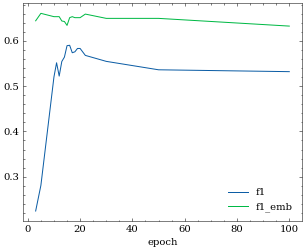

In [11]:
import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())

fig, ax = plt.subplots(figsize=(5,4))

performance = pd.DataFrame(data={"epoch": epochs, "f1": f1s, "f1_emb": f1s_emb})
performance.plot(x="epoch", y="f1", ax=ax)
performance.plot(x="epoch", y="f1_emb", ax=ax)

plt.savefig("images/003_fasttext_hyperopt.png")
plt.savefig("images/003_fasttext_hyperopt.pdf")